- Do:
    - organize tests for stationarity
    - modularize

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics
import os
import glob
import json
import warnings
import itertools
import statsmodels.api as sm

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')


df = pd.read_csv("./routes.csv", sep='\t')
df.head()

,passenger_id,source_latitude,source_longitude,source_address,destination_latitude,destination_longitude,destination_address,request_date
0,41037,-12.088156,-77.016065,"Avenida Nicolás de Arriola 314, La Victoria 13",-12.108531,-77.044891,"Calle Carlos Graña Elisande 340, San Isidro 27",2015-09-01 00:00:04
1,116591,-12.099957,-77.036497,"Av Los Conquistadores 392, San Isidro 15073",-12.119686,-76.999969,"Bruselas 228, La Calera De La Merced",2015-09-01 00:00:15
2,86426,-12.099153,-77.019425,"Av. República de Panamá 3537, San Isidro 27",-12.076505,-77.089305,"Av. La Marina cdra. 25, San Miguel 32",2015-09-01 00:00:17
3,53610,-12.110271,-77.028945,"Junín 225, Miraflores",-12.132221,-77.027021,"Calle San Fernando 380, Miraflores 18",2015-09-01 00:00:29
4,102927,-12.098430,-77.026246,"Av. República De Colombia 791, San Isidro",-12.099529,-76.990486,"Calle Mozart 201, San Borja 41",2015-09-01 00:00:31


### Check for NaN values & Clean

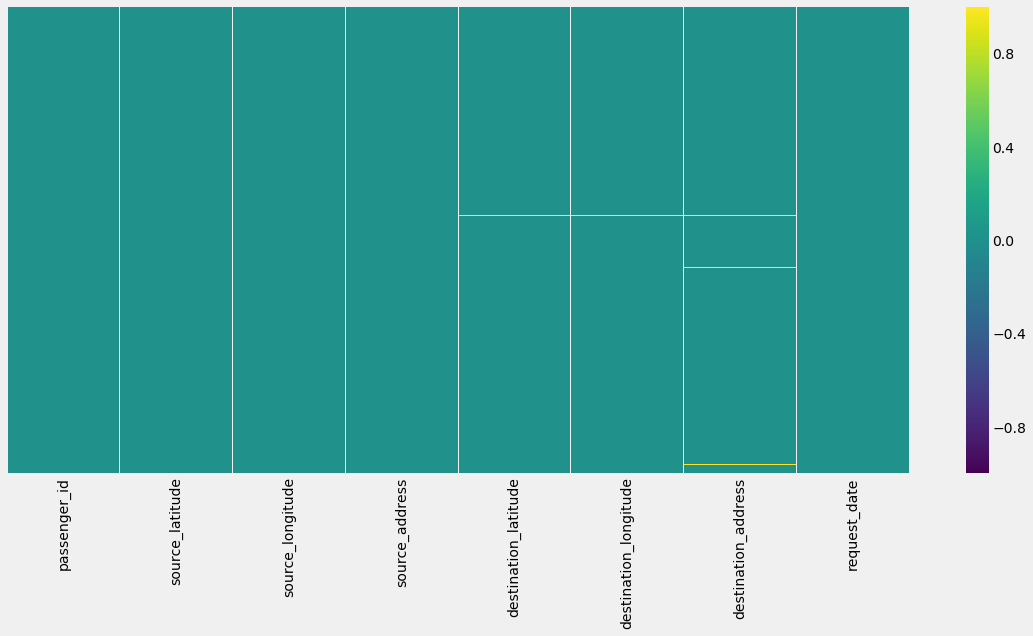

In [69]:
sns_plot = sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis'
           #,vmax=1.0, vmin=-1.0   # these solve the boolean - problem
           )

sns_plot.figure.savefig("missingdata.png")

In [2]:
print(len(df[df.isnull().any(axis=1)] )/len(df))              # 0.5% NaN values - we drop them

0.004497227736326922


In [3]:
df = df.dropna() 

### Cluster based on Locations

In [106]:
outputfolder = './clustering'

Running KMeans for Source and Destination
Trying K in range(5, 30)


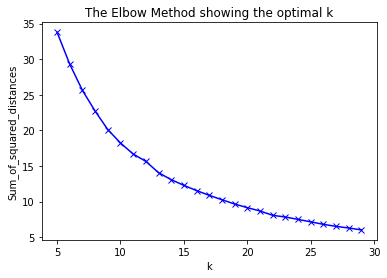

In [74]:


def clusterGeodataPrepare(data):
    df_source = data[['source_latitude', 'source_longitude']]
    df_dest = data[['destination_latitude', 'destination_longitude']]

    df_source.columns = ['latitude', 'longitude']
    df_dest.columns = ['latitude', 'longitude']

    df_geo = pd.concat([df_source, df_dest])
    df_geo = df_geo.dropna()
    return df_geo

def clusterGeodataExploration(df_geo, outputfolder):
        distortions = []
        K = range(5,30)
        """
        Creates kMeans model of centroids based on source and destination longitudes and latitudes
        Args:
            data (pd.DataFrame)
            n_clusters (int)
        Returns:
            data (pd.DataFrame): new dataframe with two new columns
            with the predicted source and destination based on the clustering
            algorithm
        """
        
        print("Running KMeans for Source and Destination")
        print("Trying K in "+str(K))
        
        # Explore K
        for k in K:
            kmeanModel = KMeans(n_clusters=k, n_jobs=-1).fit(df_geo)
            #distortions.append(sum(np.min(cdist(df_geo, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_geo.shape[0])
            distortions.append(kmeanModel.inertia_)
            
        # Plot the elbow
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('The Elbow Method showing the optimal k')
        if not os.path.exists(outputfolder):
            os.mkdir(outputfolder)
        plt.savefig(outputfolder+'/elbow_rule.png')
        plt.show()

    
def clusterGeodata(data, df_geo, k=15):                                    # default after elbow rule
    kmeans_model = KMeans(n_clusters=k, n_jobs=-1).fit(df_geo)
    data['pred_source'] = kmeans_model.predict(data[['source_latitude', 'source_longitude']])
    data['pred_destination'] = kmeans_model.predict(data[['destination_latitude', 'destination_longitude']])
    return data
    
sample = df.sample(frac=0.01)
df_geo = clusterGeodataPrepare(sample)
clusterGeodataExploration(df_geo)                 # show right K
clustereddf = clusterGeodata(sample, df_geo)

### Map

In [76]:
len(clustereddf)

20361

In [75]:
clustereddf.head()

,passenger_id,source_latitude,source_longitude,source_address,destination_latitude,destination_longitude,destination_address,request_date,pred_source,pred_destination
1431272,205321,-12.098750,-77.006140,"Avenida de las Artes Sur 347, San Borja 41",-12.074559,-76.990022,"Av CircunvalaciónUrb. Salamanca, Ate 3",2015-12-11 05:38:20,0,0
584193,263516,-12.114639,-77.045273,"Calle General Manuel Mendiburu Nº 562, Lima",-12.093436,-77.027343,"Calle Deán Valdivia 148, San Isidro 27",2015-10-20 13:33:37,7,7
871132,26135,-12.086880,-77.070206,"Jirón Ayacucho 624, Magdalena del Mar 17",-12.098410,-77.026627,"Av Republica de Colombia 791, Lima",2015-11-09 12:42:57,3,7
255285,160652,-12.163432,-76.987420,"Calle Guia Gonzales, Santiago de Surco 33",-12.080910,-76.979988,"Calle Los Mojaves 142, Ate 3",2015-09-22 04:20:16,9,2
1512594,296487,-12.062173,-77.022724,"Avenida 28 de Julio 1905, La Victoria 13",-12.089310,-77.065380,"Avenida Brasil Cuadra 32, Magdalena del Mar 17",2015-12-14 11:49:05,11,3


In [77]:
# Keep this information to download map from https://

decimals = 4         # to round the coordinates

sourceDict = {'longitude_max': np.around(clustereddf['source_longitude'].max(), decimals=decimals), 
              'longitude_min': np.around(clustereddf['source_longitude'].min(), decimals=decimals), 
              'latitude_max': np.around(clustereddf['source_latitude'].max(), decimals=decimals), 
              'latitude_min': np.around(clustereddf['source_latitude'].min(), decimals=decimals)}

destinationDict = {'longitude_max': np.around(clustereddf['destination_longitude'].max(), decimals=decimals), 
              'longitude_min': np.around(clustereddf['destination_longitude'].min(), decimals=decimals), 
              'latitude_max': np.around(clustereddf['destination_latitude'].max(), decimals=decimals), 
              'latitude_min': np.around(clustereddf['destination_latitude'].min(), decimals=decimals)}

sourceDict

{'longitude_max': -76.6947,
 'longitude_min': -77.1719,
 'latitude_max': -11.8326,
 'latitude_min': -12.3648}

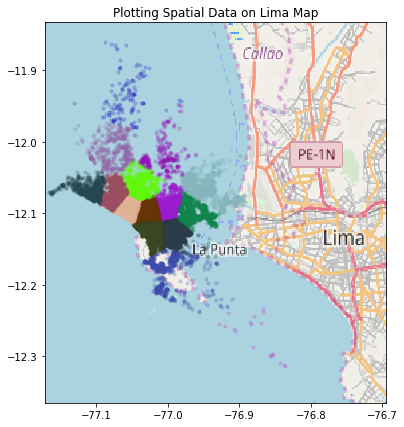

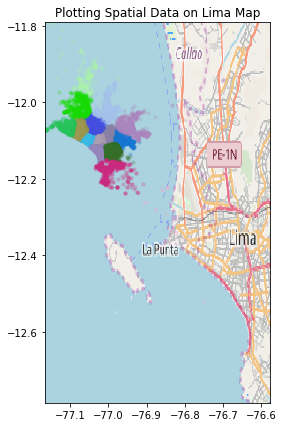

In [109]:
import matplotlib.cm as cm


def drawClusters(clustereddf, outputfolder, sd):
    assert sd=='source' or sd=='destination'
    
    clusters = len(clustereddf['pred_'+str(sd)].unique())
    x = np.arange(clusters+1)
    ys = [i+x+(i*x)**2 for i in range(clusters+1)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))


    ruh_m = plt.imread('./limaMap.png')

    BBox = ((clustereddf[str(sd)+'_longitude'].min(),   
             clustereddf[str(sd)+'_longitude'].max(),      
             clustereddf[str(sd)+'_latitude'].min(), 
             clustereddf[str(sd)+'_latitude'].max()))

    fig, ax = plt.subplots(figsize = (8,7))

    # For all Clusters

    num=0
    #for k,c in zip(clustereddf['pred_'+str(sd)].unique(), colors):
    for k in clustereddf['pred_'+str(sd)].unique():
        #num+=1
        
        ax.scatter(clustereddf[clustereddf['pred_'+str(sd)]==k][str(sd)+'_longitude'], 
                   clustereddf[clustereddf['pred_'+str(sd)]==k][str(sd)+'_latitude'], 
                   zorder=1, alpha= 0.2, c=[np.random.rand(3,)], s=10)                  # random color
        #print(num)

    ax.set_title('Plotting Spatial Data on Lima Map')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
    fig.savefig(str(outputfolder)+'/Clustermap_'+str(sd)+'.png')

drawClusters(clustereddf, outputfolder, 'source')
drawClusters(clustereddf, outputfolder, 'destination')

### Merge with weather data

In [3]:
weather_datapath = './weather_data'

def load_weather_data(weather_datapath):
        """
        Weather dataloader
        Args:
            weather_datapath (str): Folder path that contains json files
            downloaded from WorldWeatherOnline.com
        Returns:
            pd.DataFrame: Dataframe that contains weather data in correct
            datetime format. In our case we include only temperature(C), 
            windspeed and precipitation(mm) as features.              
        """
        filenames = glob.glob(weather_datapath + "/*.json")
        filenames = sorted(filenames)
        print(filenames)

        def open_file(filename):
            with open(filename) as f:
                df = json.load(f)
            df = pd.DataFrame(df['data']['weather'])
            return df

        def get_daily_data(df):
            hourly_data = pd.DataFrame(df['hourly'])
            hourly_data['date'] = df['date']
            return hourly_data

        def get_data_from_file(df):
            time_dfs = [get_daily_data(df.iloc[x]) for x in range(len(df))]
            file_df = pd.concat(time_dfs)
            return file_df

        def format_time(time):
            time = str(time)
            if time == "0":
                return "00:00:00"
            elif time == "1000":
                return "10:00:00"
            elif time == "2000":
                return "20:00:00"
            else:
                time = time.replace("00", ":00")
                new_time = time+":00"
                if len(new_time) < 8:
                    new_time = "0"+new_time
                return new_time

        file_dfs = [get_data_from_file(open_file(filename)) for filename in filenames]
        weatherdata = pd.concat(file_dfs)
        weatherdata['time'] = weatherdata['time'].apply(lambda x: format_time(x))
        weatherdata['datetime'] = weatherdata['date'] + ' ' + weatherdata['time']
        weatherdata['datetime'] = weatherdata['datetime'].astype('datetime64[s]')
        weatherdata[['tempC', 'precipMM', 'WindGustKmph']] = \
            weatherdata[['tempC', 'precipMM', 'WindGustKmph']].astype(float)
        weatherdata = weatherdata[['datetime', 'tempC', 'precipMM', 'WindGustKmph']]
        return weatherdata
    
dfw = load_weather_data(weather_datapath)
dfw.set_index('datetime', inplace=True)
#dfw = dfw.asfreq(freq='h')
print(len(dfw))
print(len(dfw[dfw.isnull().any(axis=1)]))
dfw.head()

['./weather_data\\weather_1.json', './weather_data\\weather_2.json', './weather_data\\weather_3.json', './weather_data\\weather_4.json']
2922
0


,tempC,precipMM,WindGustKmph
datetime,,,
2015-09-01 00:00:00,16.0,0.0,17.0
2015-09-01 01:00:00,16.0,0.0,17.0
2015-09-01 02:00:00,15.0,0.0,18.0
2015-09-01 03:00:00,15.0,0.0,18.0
2015-09-01 04:00:00,16.0,0.0,15.0


In [6]:
dfw.rename(columns={"tempC":"Temperature", 'precipitation':'Precipitation', 'WindGustKmph':'WindSpeed'}, inplace=True)
dfw.head()
dfw.to_csv("lima_2015_weatherdata.csv")

### Resample

In [4]:
df["request_date"]= pd.to_datetime(df["request_date"]) 
print(type(df["request_date"][0]))                          # verify it worked
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,passenger_id,source_latitude,source_longitude,source_address,destination_latitude,destination_longitude,destination_address,request_date
0,41037,-12.088156,-77.016065,"Avenida Nicolás de Arriola 314, La Victoria 13",-12.108531,-77.044891,"Calle Carlos Graña Elisande 340, San Isidro 27",2015-09-01 00:00:04
1,116591,-12.099957,-77.036497,"Av Los Conquistadores 392, San Isidro 15073",-12.119686,-76.999969,"Bruselas 228, La Calera De La Merced",2015-09-01 00:00:15
2,86426,-12.099153,-77.019425,"Av. República de Panamá 3537, San Isidro 27",-12.076505,-77.089305,"Av. La Marina cdra. 25, San Miguel 32",2015-09-01 00:00:17
3,53610,-12.110271,-77.028945,"Junín 225, Miraflores",-12.132221,-77.027021,"Calle San Fernando 380, Miraflores 18",2015-09-01 00:00:29
4,102927,-12.098430,-77.026246,"Av. República De Colombia 791, San Isidro",-12.099529,-76.990486,"Calle Mozart 201, San Borja 41",2015-09-01 00:00:31


In [7]:
df3 = df.resample('h', on = 'request_date').count()


df3.drop(columns=['request_date'], inplace=True)
#df3.reset_index(inplace=True)
df3 = df3.rename(columns={'passenger_id': 'requests'})
#df3 = df3[['date', 'requests']]
df3 = df3[['requests']]
print("New length is "+str(len(df3)))
print(len(df3[df3.isnull().any(axis=1)]))
df3.head()

New length is 2905
0


,requests
request_date,
2015-09-01 00:00:00,708
2015-09-01 01:00:00,479
2015-09-01 02:00:00,492
2015-09-01 03:00:00,563
2015-09-01 04:00:00,355


In [10]:
print(len(dfw))
dfw.head()

2922


,tempC,precipMM,WindGustKmph
datetime,,,
2015-09-01 00:00:00,16.0,0.0,17.0
2015-09-01 01:00:00,16.0,0.0,17.0
2015-09-01 02:00:00,15.0,0.0,18.0
2015-09-01 03:00:00,15.0,0.0,18.0
2015-09-01 04:00:00,16.0,0.0,15.0


In [13]:
df3.head()

,request_date,requests
0,2015-09-01 00:00:00,708
1,2015-09-01 01:00:00,479
2,2015-09-01 02:00:00,492
3,2015-09-01 03:00:00,563
4,2015-09-01 04:00:00,355


In [14]:
dfw.head()

,datetime,tempC,precipMM,WindGustKmph
0,2015-09-01 00:00:00,16.0,0.0,17.0
1,2015-09-01 01:00:00,16.0,0.0,17.0
2,2015-09-01 02:00:00,15.0,0.0,18.0
3,2015-09-01 03:00:00,15.0,0.0,18.0
4,2015-09-01 04:00:00,16.0,0.0,15.0


In [11]:
df3 = df3.reset_index()
dfw = dfw.reset_index()

In [12]:
totaldf = df3.merge(dfw, left_on='request_date', right_on='datetime', how='left')



#totaldf.drop(columns=['datetime'], inplace=True)
print(len(totaldf))
totaldf = totaldf.fillna(totaldf.mean())                              # impute 6 missing values with mean
totaldf.drop(columns=['datetime'], inplace=True)
print(len(totaldf[totaldf.isnull().any(axis=1)]))
totaldf[totaldf.isnull().any(axis=1)].head()
#totaldf.head()

2905
0


,request_date,requests,tempC,precipMM,WindGustKmph


### Plots

ValueError: Could not interpret input 'date'

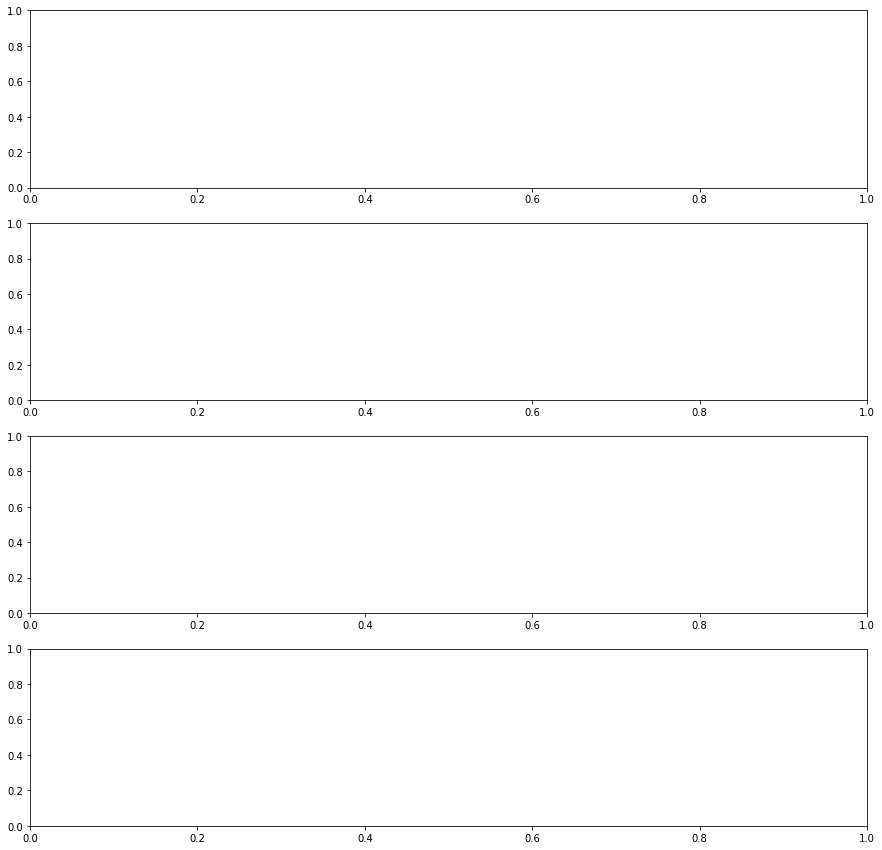

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,15))

lol = sns.lineplot(x='date', y='requests', color="indianred", data=totaldf, ax=axs[0])

for item in lol.get_xticklabels():
    item.set_rotation(45)

lol = sns.lineplot(x='date', y='tempC', color="blue", data=totaldf, ax=axs[1])

for item in lol.get_xticklabels():
    item.set_rotation(45)
    
lol = sns.lineplot(x='date', y='precipMM', color="green", data=totaldf, ax=axs[2])

for item in lol.get_xticklabels():
    item.set_rotation(45)
    
lol = sns.lineplot(x='date', y='WindGustKmph', color="black", data=totaldf, ax=axs[3])

for item in lol.get_xticklabels():
    item.set_rotation(45)

### TS Decomposition

In [21]:
totaldf.columns
print(len(totaldf))
print(len(totaldf[totaldf.isnull().any(axis=1)]))
totaldf.head()

2905
0


,request_date,requests,tempC,precipMM,WindGustKmph
0,2015-09-01 00:00:00,708,16.0,0.0,17.0
1,2015-09-01 01:00:00,479,16.0,0.0,17.0
2,2015-09-01 02:00:00,492,15.0,0.0,18.0
3,2015-09-01 03:00:00,563,15.0,0.0,18.0
4,2015-09-01 04:00:00,355,16.0,0.0,15.0


In [16]:
temp = totaldf[['request_date', 'requests']]
#temp['datetime'] = pd.to_datetime(temp['date'])
temp = temp.set_index('request_date')
#temp.set_index('date', inplace=True)
temp = temp.asfreq(freq='h')
print(len(temp[temp.isnull().any(axis=1)]))
print(temp.index)
temp.head()

0
DatetimeIndex(['2015-09-01 00:00:00', '2015-09-01 01:00:00',
               '2015-09-01 02:00:00', '2015-09-01 03:00:00',
               '2015-09-01 04:00:00', '2015-09-01 05:00:00',
               '2015-09-01 06:00:00', '2015-09-01 07:00:00',
               '2015-09-01 08:00:00', '2015-09-01 09:00:00',
               ...
               '2015-12-30 15:00:00', '2015-12-30 16:00:00',
               '2015-12-30 17:00:00', '2015-12-30 18:00:00',
               '2015-12-30 19:00:00', '2015-12-30 20:00:00',
               '2015-12-30 21:00:00', '2015-12-30 22:00:00',
               '2015-12-30 23:00:00', '2015-12-31 00:00:00'],
              dtype='datetime64[ns]', name='request_date', length=2905, freq='H')


,requests
request_date,
2015-09-01 00:00:00,708
2015-09-01 01:00:00,479
2015-09-01 02:00:00,492
2015-09-01 03:00:00,563
2015-09-01 04:00:00,355


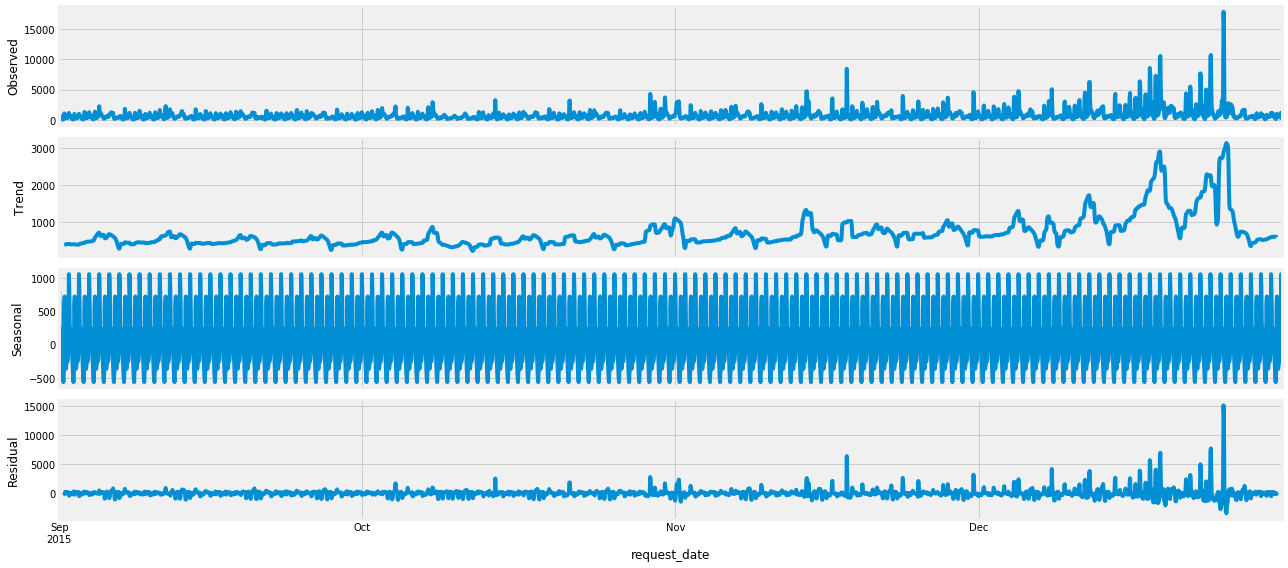

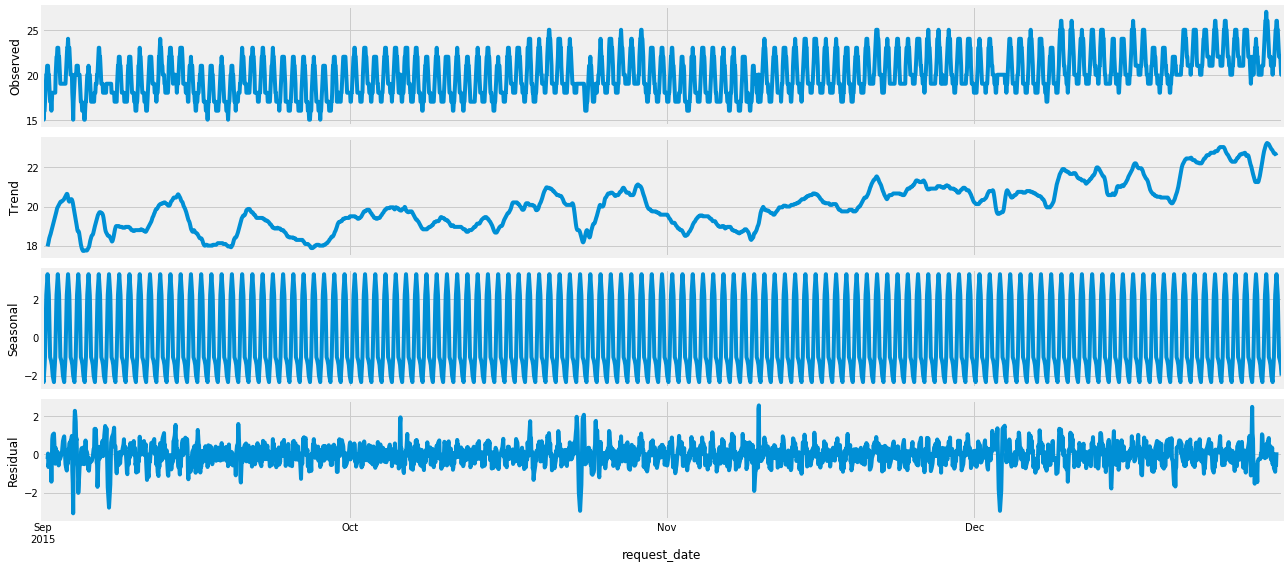

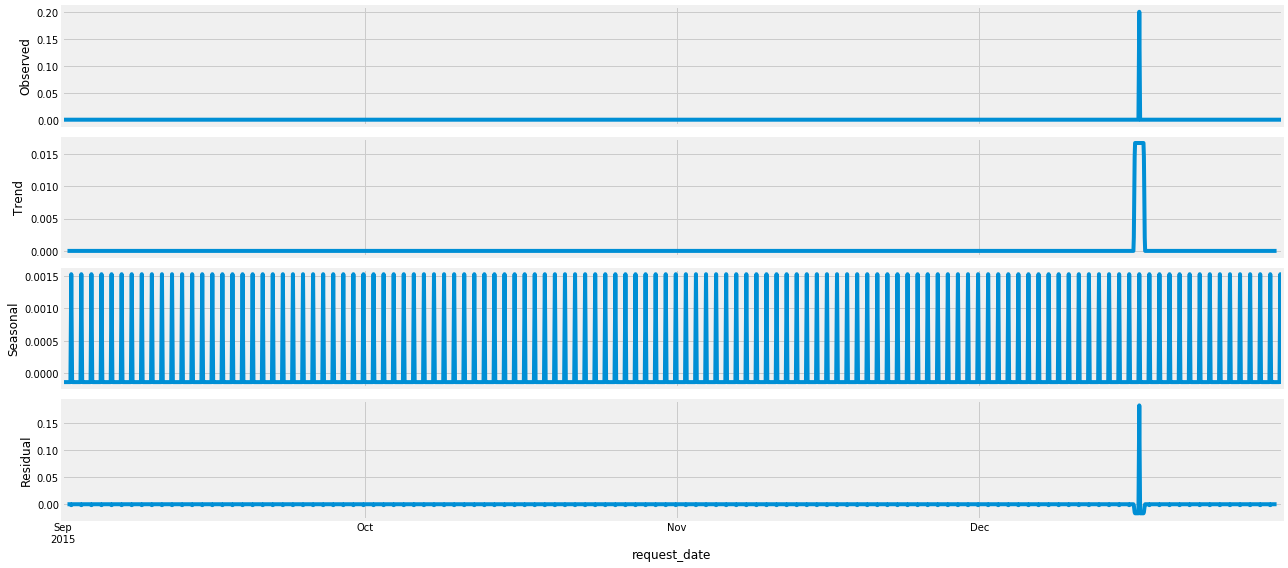

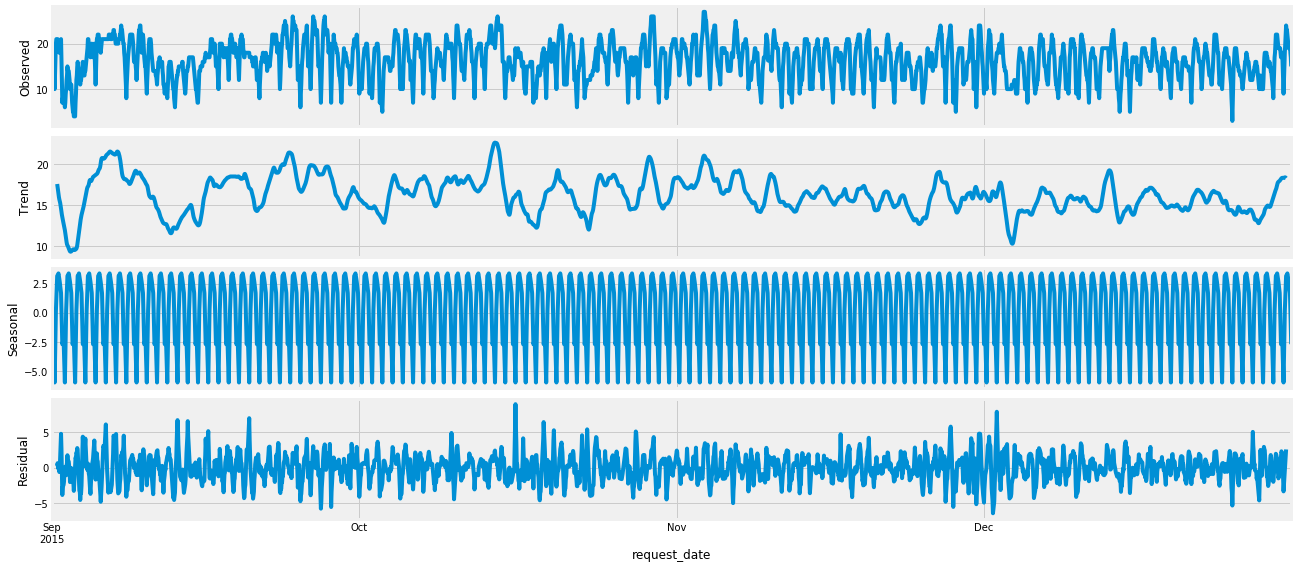

In [17]:
def TSDecomposition(totaldf):
    usefulcols = ['requests', 'tempC', 'precipMM', 'WindGustKmph']
    outputpath = './TS Decomposition/'

    for col in usefulcols:
        temp = totaldf[['request_date', col]]
        temp = temp.set_index('request_date')
        temp = temp.asfreq(freq='h')
        rcParams['figure.figsize'] = 18, 8
        decomposition = sm.tsa.seasonal_decompose(temp, model='additive')
        fig = decomposition.plot()
        fig.savefig(outputpath+'/Decomposition_'+str(col)+'.png')
        #plt.show()
        
TSDecomposition(totaldf)

In [18]:
temp.head()

,requests
request_date,
2015-09-01 00:00:00,708
2015-09-01 01:00:00,479
2015-09-01 02:00:00,492
2015-09-01 03:00:00,563
2015-09-01 04:00:00,355


### Stationarity: mean, variance and covariance dont vary over time
### it should not exhibit a trend!

 - ADF (Augmented Dickey Fuller) Test (for stationarity)
     - Null Hypothesis: The series has a unit root (value of a =1)
     - We want to reject H0!

In [45]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(totaldf['requests'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.821514
p-value                           0.000049
#Lags Used                       28.000000
Number of Observations Used    2876.000000
Critical Value (1%)              -3.432626
Critical Value (5%)              -2.862545
Critical Value (10%)             -2.567305
dtype: float64


In [46]:
adf_test(totaldf['tempC'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.409897
p-value                           0.010626
#Lags Used                       28.000000
Number of Observations Used    2876.000000
Critical Value (1%)              -3.432626
Critical Value (5%)              -2.862545
Critical Value (10%)             -2.567305
dtype: float64


In [47]:
adf_test(totaldf['precipMM'])

Results of Dickey-Fuller Test:
Test Statistic                -9.338873e+00
p-value                        8.908239e-16
#Lags Used                     2.800000e+01
Number of Observations Used    2.876000e+03
Critical Value (1%)           -3.432626e+00
Critical Value (5%)           -2.862545e+00
Critical Value (10%)          -2.567305e+00
dtype: float64


In [52]:
adf_test(totaldf['WindGustKmph'])

Results of Dickey-Fuller Test:
Test Statistic                -7.526968e+00
p-value                        3.663009e-11
#Lags Used                     2.700000e+01
Number of Observations Used    2.877000e+03
Critical Value (1%)           -3.432625e+00
Critical Value (5%)           -2.862545e+00
Critical Value (10%)          -2.567305e+00
dtype: float64


In [58]:
from statsmodels.tsa.stattools import kpss

#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [61]:
kpss_test(totaldf['requests'])

Results of KPSS Test:
Test Statistic            3.585869
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [62]:
kpss_test(totaldf['tempC'])

Results of KPSS Test:
Test Statistic            5.917476
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [63]:
kpss_test(totaldf['precipMM'])

Results of KPSS Test:
Test Statistic            0.238714
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [64]:
kpss_test(totaldf['WindGustKmph'])

Results of KPSS Test:
Test Statistic            0.707040
p-value                   0.012905
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### All of our TS features are stationary, as Test-statistic is lower than 5% critical value (or p-value<0.05)!

## Save to .csv

In [55]:
totaldf.head()

,request_date,requests,tempC,precipMM,WindGustKmph
0,2015-09-01 00:00:00,708,16.0,0.0,17.0
1,2015-09-01 01:00:00,479,16.0,0.0,17.0
2,2015-09-01 02:00:00,492,15.0,0.0,18.0
3,2015-09-01 03:00:00,563,15.0,0.0,18.0
4,2015-09-01 04:00:00,355,16.0,0.0,15.0


In [56]:
totaldf.to_csv("./totaldf.csv", index=False)